In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data=pd.read_csv('dataset.csv')
data

,Kode Produk,19-Jan,19-Feb,19-Mar,19-Apr,19-May,19-Jun,19-Jul,19-Aug,19-Sep,...,20-Apr,20-May,20-Jun,20-Jul,20-Aug,20-Sep,20-Oct,20-Nov,20-Dec,Cluster
0,P1,56,7,8,14,16,10,21,20,68,...,17,6,9,62,67,62,67,77,11,0
1,P2,164,190,188,164,235,139,662,240,138,...,367,227,55,222,220,85,336,153,103,1
2,P3,65,58,79,109,50,51,73,92,28,...,121,23,30,26,19,23,21,20,7,0
3,P4,243,304,321,241,191,97,276,165,170,...,304,72,102,102,113,112,102,118,120,1
4,P5,10,13,24,14,28,9,19,10,24,...,16,11,7,10,16,18,18,23,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,P154,243,379,292,232,287,107,344,455,436,...,129,85,115,232,79,112,450,498,254,1
154,P155,-5,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,P156,101,65,117,94,197,151,157,159,144,...,152,129,136,177,120,167,153,130,121,1
156,P157,0,0,0,0,0,8,49,93,103,...,19,26,29,49,43,34,51,51,43,0


In [3]:
len(data['Cluster'].unique())

5

In [4]:
#now lets take clusters
c0 = data.query("Cluster == 0")
print("Jumlah Produk:")
print(c0['Kode Produk'].size)
c1 = data.query("Cluster == 1")
print("Jumlah Produk:")
print(c1['Kode Produk'].size)
c2 = data.query("Cluster == 2")
print("Jumlah Produk:")
print(c2['Kode Produk'].size)
c3 = data.query("Cluster == 3")
print("Jumlah Produk:")
print(c3['Kode Produk'].size)
c4 = data.query("Cluster == 4")
print("Jumlah Produk:")
print(c4['Kode Produk'].size)

Jumlah Produk:
96
Jumlah Produk:
45
Jumlah Produk:
1
Jumlah Produk:
3
Jumlah Produk:
13


In [5]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

# C2

In [9]:
#next kita ubah bentuk data nya dari yang tadinya kesamping jadi ke bawah, tapi pertama mau aku drop dulu cluster sama kode produknya
c2=c2.drop(columns=['Kode Produk','Cluster'])
c2

,19-Jan,19-Feb,19-Mar,19-Apr,19-May,19-Jun,19-Jul,19-Aug,19-Sep,19-Oct,...,20-Mar,20-Apr,20-May,20-Jun,20-Jul,20-Aug,20-Sep,20-Oct,20-Nov,20-Dec
79,4624,959,1500,4900,1812,2128,3913,5320,2657,4730,...,3682,3585,6316,2531,3752,2508,3637,3854,3951,3220


In [71]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, 
new_c2=[]
time=[]
for idx,_ in enumerate(c2):
    new_c2.append(c2.iloc[0,idx])
    time.append(idx)
print(time,new_c2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] [4624, 959, 1500, 4900, 1812, 2128, 3913, 5320, 2657, 4730, 181, 2337, 2382, 1005, 3682, 3585, 6316, 2531, 3752, 2508, 3637, 3854, 3951, 3220]


In [72]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c2
min = np.min(series)
max = np.max(series)
series = series - min
series = series / max
time = np.array(time)

In [73]:
series

array([0.70345155, 0.12317923, 0.20883471, 0.74715009, 0.25823306,
       0.30826472, 0.5908803 , 0.81364788, 0.39202027, 0.72023433,
       0.        , 0.34135529, 0.34848005, 0.13046232, 0.55430652,
       0.5389487 , 0.97134262, 0.37207093, 0.56538949, 0.36842939,
       0.54718176, 0.58153895, 0.59689677, 0.48115896])

In [74]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:split_time]
x_train =  series[:split_time]
time_valid =  time[split_time:]
x_valid =  series[split_time:]

In [75]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [93]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=[None, 1], activation="relu"),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)
    ])

    #the blstm part

In [94]:
#Using mae and mse
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=100,validation_data=valid_set)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, None, 2)           4         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 64)                8960      
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

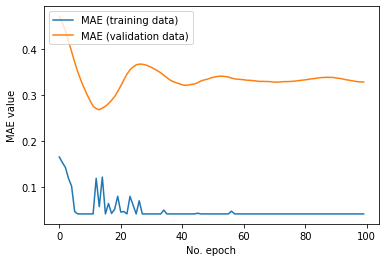

In [91]:
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [95]:
prediksi=model.predict([21, 22, 23])
prediksi

array([[0.18251646],
       [0.18189527],
       [0.1812896 ]], dtype=float32)

In [96]:
import matplotlib.pyplot as plt


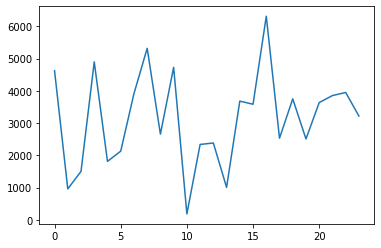

In [97]:
series = series * max
series = series + min
plt.plot(series)

In [98]:
prediksi = prediksi * max
prediksi = prediksi + min
prediksi

array([[1333.7739],
       [1329.8506],
       [1326.0251]], dtype=float32)

In [99]:
prediksi=prediksi.flatten()

In [100]:
hasil=np.concatenate((series[:-split_time],prediksi))

In [101]:
hasil

array([4624.        ,  959.        , 1500.        , 4900.        ,
       1812.        , 2128.        , 3913.        , 5320.        ,
       2657.        , 4730.        ,  181.        , 2337.        ,
       2382.        , 1005.        , 3682.        , 3585.        ,
       6316.        , 2531.        , 3752.        , 2508.        ,
       3637.        , 1333.77392578, 1329.85058594, 1326.02514648])

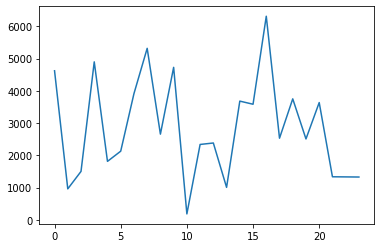

In [102]:
plt.plot(hasil)

# C0

In [6]:
## do the same for the others, tapi karena yang lain punya beberapa anggota, nah itu di average dulu per tanggalnya
c0=c0.drop(columns=['Kode Produk', 'Cluster'])


In [22]:
p1=c0.iloc[0]
p1=p1.values.tolist()
p1

[56,
 7,
 8,
 14,
 16,
 10,
 21,
 20,
 68,
 21,
 37,
 55,
 58,
 7,
 59,
 17,
 6,
 9,
 62,
 67,
 62,
 67,
 77,
 11]

In [8]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c0=[]
time=[]
for idx,a in enumerate(c0):
    new_c0.append(c0[a].mean())
    time.append(idx)


In [9]:
new_c0

[28.010416666666668,
 25.8125,
 26.0,
 24.8125,
 28.427083333333332,
 15.791666666666666,
 31.25,
 22.510416666666668,
 30.760416666666668,
 33.020833333333336,
 28.020833333333332,
 23.677083333333332,
 27.677083333333332,
 26.78125,
 26.270833333333332,
 19.114583333333332,
 11.395833333333334,
 13.270833333333334,
 20.385416666666668,
 22.083333333333332,
 21.53125,
 15.895833333333334,
 19.885416666666668,
 19.5625]

In [10]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c0
min = np.min(series)
max = np.max(series)
series = series - min
series = series / max
time = np.array(time)

In [11]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:split_time]
x_train =  series[:split_time]
time_valid =  time[split_time:]
x_valid =  series[split_time:]

In [12]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [17]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=[None, 1], activation="relu"),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)
    ])

    #the blstm part

In [18]:
#Using mae and mse
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=100,validation_data=valid_set)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 2)           4         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                8960      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

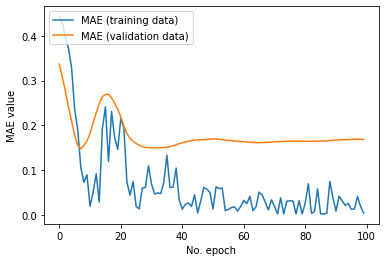

In [20]:
import matplotlib.pyplot as plt
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [21]:
prediksi=model.predict([21, 22, 23])
prediksi

array([[0.43625715],
       [0.4360152 ],
       [0.43598562]], dtype=float32)

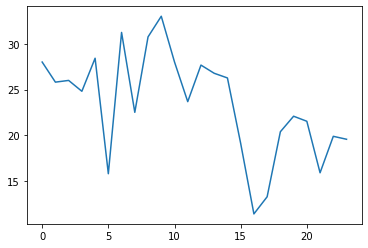

In [22]:
#data asli
series = series * max
series = series + min
plt.plot(series)

In [23]:
prediksi = prediksi * max
prediksi = prediksi + min
prediksi

array([[25.801407],
       [25.793417],
       [25.792442]], dtype=float32)

In [24]:
prediksi=prediksi.flatten()

In [25]:
hasil=np.concatenate((series[:-split_time],prediksi))

In [26]:
hasil

array([28.01041667, 25.8125    , 26.        , 24.8125    , 28.42708333,
       15.79166667, 31.25      , 22.51041667, 30.76041667, 33.02083333,
       28.02083333, 23.67708333, 27.67708333, 26.78125   , 26.27083333,
       19.11458333, 11.39583333, 13.27083333, 20.38541667, 22.08333333,
       21.53125   , 25.80140686, 25.79341698, 25.79244232])

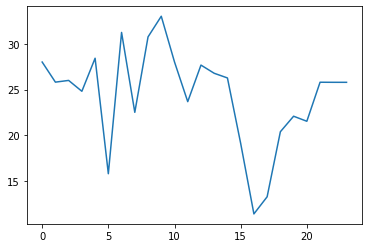

In [27]:
#data prediksi
plt.plot(hasil)

In [28]:
#simpan model, biar gak lama latih ulang pake data p1 yang baru
model.save('cluster0.h5')

In [10]:
## sekarang, kita ambil model khusus cluster 0, terus kita latih ulang lagi dikiit dengan data p1
model0=tf.keras.models.load_model('cluster0.h5')

In [23]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=p1
min = np.min(series)
max = np.max(series)
series = series - min
series = series / max
time = np.array(time)

In [24]:
series

array([0.64935065, 0.01298701, 0.02597403, 0.1038961 , 0.12987013,
       0.05194805, 0.19480519, 0.18181818, 0.80519481, 0.19480519,
       0.4025974 , 0.63636364, 0.67532468, 0.01298701, 0.68831169,
       0.14285714, 0.        , 0.03896104, 0.72727273, 0.79220779,
       0.72727273, 0.79220779, 0.92207792, 0.06493506])

In [33]:
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [25]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:split_time]
x_train =  series[:split_time]
time_valid =  time[split_time:]
x_valid =  series[split_time:]

In [26]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [34]:
model_for_p1 = tf.keras.Sequential([
        model0, 
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    #the blstm part, same thing, but retrained on ONLY THIS PRODUCT
    

In [35]:
#Using mae and mse
model_for_p1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),metrics=['mae'],loss='mse')
model_for_p1.summary()
hist_p1=model_for_p1.fit(train_set,epochs=20,validation_data=valid_set)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1)                 44165     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 44,358
Trainable params: 44,358
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.0072 - mae: 0.0847 - val_loss: 0.2140 - val_mae: 0.3602
Epoch 2/20
1/1 [==============================] - 0s 135ms/step - loss: 0.0069 - mae: 0.0828 - val_loss: 0.2140 - val_mae: 0.3603
Epoch 3/20
1/1 [==============================] - 0s 113ms/step - loss: 0.0062 - mae: 0.0783 - val_loss: 0.2141 - val_mae: 

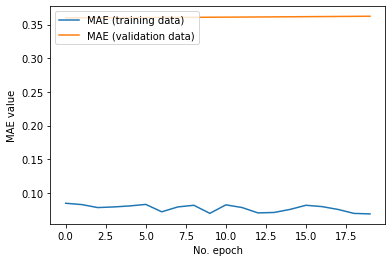

In [36]:
import matplotlib.pyplot as plt
plt.plot(hist_p1.history['mae'], label='MAE (training data)')
plt.plot(hist_p1.history['val_mae'], label='MAE (validation data)')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [37]:
prediksi_p1=model_for_p1.predict([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [38]:
prediksi_p1

array([[0.09047335],
       [0.09272551],
       [0.09458651],
       [0.09567694],
       [0.09711609],
       [0.09780953],
       [0.09767339],
       [0.09691504],
       [0.09613707],
       [0.09559619],
       [0.09506046],
       [0.09439807],
       [0.09382953],
       [0.09304179],
       [0.09224264],
       [0.09165154],
       [0.09118205],
       [0.0906985 ],
       [0.09036816],
       [0.09013461],
       [0.08999298],
       [0.08993283],
       [0.08988097],
       [0.08987553]], dtype=float32)

In [39]:
prediksi_p1 = prediksi_p1 * max
prediksi_p1 = prediksi_p1 + min
prediksi_p1

array([[12.966448 ],
       [13.139864 ],
       [13.283161 ],
       [13.367125 ],
       [13.47794  ],
       [13.531334 ],
       [13.520851 ],
       [13.462458 ],
       [13.4025545],
       [13.360907 ],
       [13.319655 ],
       [13.268652 ],
       [13.224874 ],
       [13.164217 ],
       [13.102683 ],
       [13.057169 ],
       [13.021017 ],
       [12.983785 ],
       [12.958348 ],
       [12.940365 ],
       [12.929459 ],
       [12.924828 ],
       [12.920835 ],
       [12.920416 ]], dtype=float32)

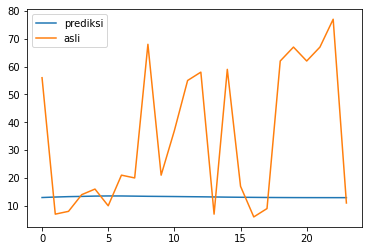

In [41]:
plt.plot(prediksi_p1, label='prediksi')
plt.plot(p1, label='asli')
plt.legend(loc="upper left")
plt.show()

# C1

In [131]:
## do the same for the others, tapi karena yang lain punya beberapa anggota, nah itu di average dulu per tanggalnya
c1=c1.drop(columns=['Kode Produk', 'Cluster'])

In [132]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c1=[]
time=[]
for idx,a in enumerate(c0):
    new_c1.append(c1[a].mean())
    time.append(idx)


In [133]:
values

[28.010416666666668,
 25.8125,
 26.0,
 24.8125,
 28.427083333333332,
 15.791666666666666,
 31.25,
 22.510416666666668,
 30.760416666666668,
 33.020833333333336,
 28.020833333333332,
 23.677083333333332,
 27.677083333333332,
 26.78125,
 26.270833333333332,
 19.114583333333332,
 11.395833333333334,
 13.270833333333334,
 20.385416666666668,
 22.083333333333332,
 21.53125,
 15.895833333333334,
 19.885416666666668,
 19.5625]

In [134]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c1
min = np.min(series)
max = np.max(series)
series = series - min
series = series / max
time = np.array(time)

In [135]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:split_time]
x_train =  series[:split_time]
time_valid =  time[split_time:]
x_valid =  series[split_time:]

In [136]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [137]:
#Using mae and mse
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=100,validation_data=valid_set)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, None, 2)           4         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 64)                8960      
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

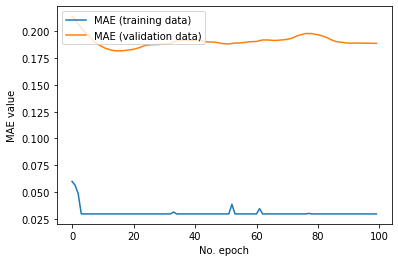

In [138]:
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [139]:
prediksi=model.predict([21, 22, 23])
prediksi

array([[0.4270295],
       [0.4262946],
       [0.4255798]], dtype=float32)

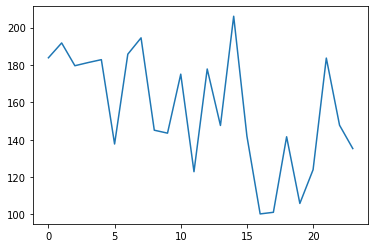

In [140]:
#data asli
series = series * max
series = series + min
plt.plot(series)

In [141]:
prediksi = prediksi * max
prediksi = prediksi + min
prediksi

array([[188.26645],
       [188.11505],
       [187.96777]], dtype=float32)

In [142]:
prediksi=prediksi.flatten()

In [143]:
hasil=np.concatenate((series[:-split_time],prediksi))

In [144]:
hasil

array([183.8       , 191.73333333, 179.55555556, 181.24444444,
       182.8       , 137.68888889, 185.73333333, 194.46666667,
       145.06666667, 143.48888889, 175.04444444, 122.86666667,
       177.8       , 147.6       , 206.02222222, 141.91111111,
       100.28888889, 101.15555556, 141.55555556, 105.88888889,
       123.93333333, 188.26644897, 188.11505127, 187.96777344])

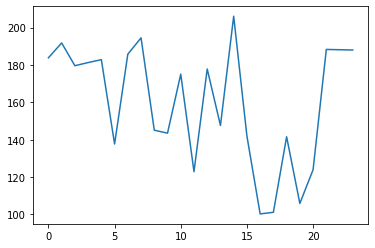

In [145]:
#data prediksi
plt.plot(hasil)

# C3

In [146]:
## do the same for the others, tapi karena yang lain punya beberapa anggota, nah itu di average dulu per tanggalnya
c3=c3.drop(columns=['Kode Produk', 'Cluster'])

In [147]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c3=[]
time=[]
for idx,a in enumerate(c0):
    new_c3.append(c3[a].mean())
    time.append(idx)


In [148]:
values

[28.010416666666668,
 25.8125,
 26.0,
 24.8125,
 28.427083333333332,
 15.791666666666666,
 31.25,
 22.510416666666668,
 30.760416666666668,
 33.020833333333336,
 28.020833333333332,
 23.677083333333332,
 27.677083333333332,
 26.78125,
 26.270833333333332,
 19.114583333333332,
 11.395833333333334,
 13.270833333333334,
 20.385416666666668,
 22.083333333333332,
 21.53125,
 15.895833333333334,
 19.885416666666668,
 19.5625]

In [149]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c3
min = np.min(series)
max = np.max(series)
series = series - min
series = series / max
time = np.array(time)

In [150]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:split_time]
x_train =  series[:split_time]
time_valid =  time[split_time:]
x_valid =  series[split_time:]

In [151]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [152]:
#Using mae and mse
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=100,validation_data=valid_set)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, None, 2)           4         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 64)                8960      
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

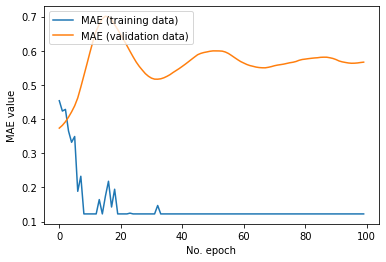

In [153]:
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [154]:
prediksi=model.predict([21, 22, 23])
prediksi

array([[0.8535772 ],
       [0.8526803 ],
       [0.85180783]], dtype=float32)

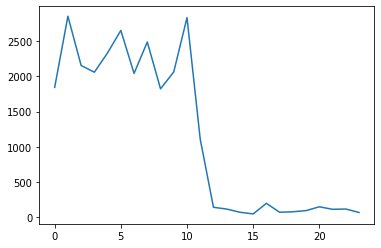

In [155]:
#data asli
series = series * max
series = series + min
plt.plot(series)

In [156]:
prediksi = prediksi * max
prediksi = prediksi + min
prediksi

array([[2483.0034],
       [2480.441 ],
       [2477.9482]], dtype=float32)

In [157]:
prediksi=prediksi.flatten()

In [158]:
hasil=np.concatenate((series[:-split_time],prediksi))

In [159]:
hasil

array([1844.66666667, 2857.        , 2156.66666667, 2060.66666667,
       2336.33333333, 2655.33333333, 2044.        , 2490.66666667,
       1824.33333333, 2065.33333333, 2837.33333333, 1107.        ,
        138.66666667,  113.33333333,   68.        ,   44.33333333,
        194.66666667,   68.        ,   74.66666667,   91.66666667,
        145.66666667, 2483.00341797, 2480.44091797, 2477.94824219])

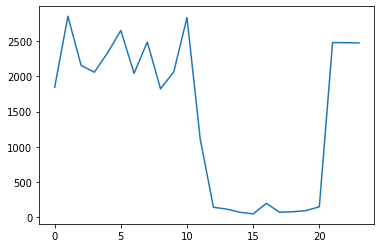

In [160]:
#data prediksi
plt.plot(hasil)

# C4

In [161]:
## do the same for the others, tapi karena yang lain punya beberapa anggota, nah itu di average dulu per tanggalnya
c4=c4.drop(columns=['Kode Produk', 'Cluster'])

In [162]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c4=[]
time=[]
for idx,a in enumerate(c0):
    new_c4.append(c4[a].mean())
    time.append(idx)


In [163]:
values

[28.010416666666668,
 25.8125,
 26.0,
 24.8125,
 28.427083333333332,
 15.791666666666666,
 31.25,
 22.510416666666668,
 30.760416666666668,
 33.020833333333336,
 28.020833333333332,
 23.677083333333332,
 27.677083333333332,
 26.78125,
 26.270833333333332,
 19.114583333333332,
 11.395833333333334,
 13.270833333333334,
 20.385416666666668,
 22.083333333333332,
 21.53125,
 15.895833333333334,
 19.885416666666668,
 19.5625]

In [164]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c0
min = np.min(series)
max = np.max(series)
series = series - min
series = series / max
time = np.array(time)

In [165]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:split_time]
x_train =  series[:split_time]
time_valid =  time[split_time:]
x_valid =  series[split_time:]

In [166]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [167]:
#Using mae and mse
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=100,validation_data=valid_set)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, None, 2)           4         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 64)                8960      
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

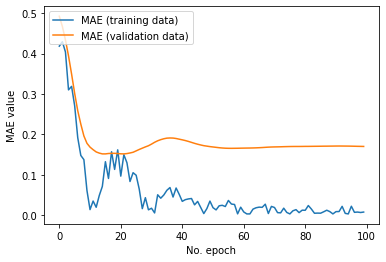

In [168]:
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [169]:
prediksi=model.predict([21, 22, 23])
prediksi

array([[0.431027  ],
       [0.43004647],
       [0.42912573]], dtype=float32)

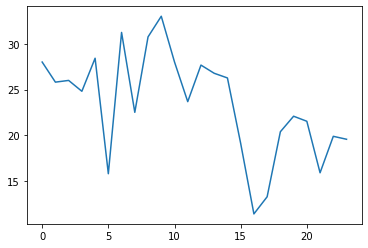

In [170]:
#data asli
series = series * max
series = series + min
plt.plot(series)

In [171]:
prediksi = prediksi * max
prediksi = prediksi + min
prediksi

array([[25.628704],
       [25.596325],
       [25.565922]], dtype=float32)

In [172]:
prediksi=prediksi.flatten()

In [173]:
hasil=np.concatenate((series[:-split_time],prediksi))

In [174]:
hasil

array([28.01041667, 25.8125    , 26.        , 24.8125    , 28.42708333,
       15.79166667, 31.25      , 22.51041667, 30.76041667, 33.02083333,
       28.02083333, 23.67708333, 27.67708333, 26.78125   , 26.27083333,
       19.11458333, 11.39583333, 13.27083333, 20.38541667, 22.08333333,
       21.53125   , 25.62870407, 25.59632492, 25.56592178])

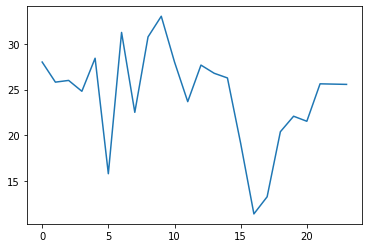

In [175]:
#data prediksi
plt.plot(hasil)